# Часть 0. Установка файлов и пакетов

In [ ]:
!pip install pymystem3 --q
!pip install pymorphy3 --q
!pip install nltk --q
!pip install spacy --q
!pip install typing_extensions --upgrade --q

In [ ]:
import pandas as pd
import json

In [ ]:
with open('/content/postoronnij.txt.txt', 'r', encoding='utf-8') as f:
    the_stranger_draft = f.readlines()
    idx = int()
    for line in the_stranger_draft:
        if 'Сегодня умерла мама' not in line: #это он берет первое предложение
            continue
        else:
            idx = the_stranger_draft.index(line)
            break
    lines_from_index = the_stranger_draft[idx:]
    the_stranger_text = ''.join(lines_from_index)

# Часть 1. Работа с NLTK и Pymorphy

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
from pymorphy3 import MorphAnalyzer
morph = MorphAnalyzer()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


###Работа со стоп-словами

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
the_stranger_tokenised = [w.lower() for w in word_tokenize(the_stranger_text, language='russian') if w.isalpha()]
the_stranger_filtered = [w for w in the_stranger_tokenised if w not in sw]

In [ ]:
#этого можно было не делать, но мне нравится мысль сохранить вторую версию файла, где уже нет пунктуации и стоп-слов))

with open("the_stranger.txt", "w", encoding="utf-8") as file:
    for token in the_stranger_filtered:
        file.write(token)
        file.write(' ')

#это, наверное, немного читерство, да? ну ничего

###Pymorphy

In [ ]:
def morph_parse(token):
    token_parsed = morph.parse(token)[0]
    return token_parsed.word, token_parsed.normal_form, token_parsed.tag.POS

In [ ]:
with open("the_stranger_file.jsonl", "w", encoding="utf-8") as file:

    for token in the_stranger_filtered:

        token_parsed = {}
        token_parsed['word'], token_parsed['lemma'], token_parsed['pos'] = morph_parse(token)[:3]

        json.dump(token_parsed, file, ensure_ascii=False)
        file.write('\n')

###Dataset

In [ ]:
with open("the_stranger_file.jsonl", "r", encoding="utf-8") as file:
    the_stranger_frequency_list = []
    for line in file:
        the_stranger_frequency = json.loads(line)
        the_stranger_frequency_list.append(the_stranger_frequency)

#здесь я явно усложнила, но ладно

df_frequency = pd.DataFrame(the_stranger_frequency_list)

the_stranger_sorted = df_frequency.groupby('lemma').agg({
    'pos': 'first', #я не придумала, как разобрать разные омонимичные формы, если бы они были
    'lemma': 'count'
}).rename(columns={'lemma': 'frequency'}).sort_values('frequency', ascending=False)

the_stranger_sorted.to_csv("the_stranger_sorted.csv", sep=",", encoding='utf-8')

###N-grams

сначала надо лемматизировать текст; в черновом варианте у меня был код, который делал это обычным циклом, но это долгий вариант, эта ячейка сейчас закомменчена, а лемматизацию я делаю через майстем

In [ ]:
from pymystem3 import Mystem
m_stem = Mystem()

In [ ]:
from nltk.util import ngrams
from nltk.util import bigrams

In [ ]:
the_stranger_lemmatized = [m_stem.lemmatize(word)[0] for word in the_stranger_tokenised]

In [ ]:
the_stranger_ngrams = list(ngrams(the_stranger_lemmatized, 3))
pd.Series(the_stranger_ngrams).value_counts().head(5)

,count
"(смотреть, друг, друг)",6
"(господин, присяжный, заседатель)",3
"(мой, ходатайство, помилование)",3
"(учитывать, это, обстоятельство)",3
"(иметь, никакой, значение)",2


если использовать список без удаленных стоп-слов, самыми частыми являются либо клаузы с глаголами говорения, либо устойчивые выражения ("в конец конец" - это явно "в конце концов"); поэтому беру filtered

In [ ]:
the_stranger_lemmatized = [m_stem.lemmatize(word)[0] for word in the_stranger_filtered]

In [ ]:
the_stranger_ngrams = list(ngrams(the_stranger_lemmatized, 3))
pd.Series(the_stranger_ngrams).value_counts().head(25)

,count
"(смотреть, друг, друг)",6
"(господин, присяжный, заседатель)",3
"(мой, ходатайство, помилование)",3
"(учитывать, это, обстоятельство)",3
"(иметь, никакой, значение)",2
"(дупло, засыхать, дерево)",2
"(известный, смысл, это)",2
"(самый, конец, пляж)",2
"(немного, погодя, спрашивать)",2
"(отводить, глаз, сторона)",2


здесь уже лучше, хотя надо учитывать, что nltk считает триграммами просто стоящие рядом друг с другом слова, поэтому рядом находятся "очень любить мама" и "любить мама отвечать" - это явно одни и те же контексты (одно пересечение из двух имеющихся примеров точно должно быть); это не очень информативно.

из информативного здесь есть устойчивые выражения (иметь большое значение, смотреть друг на друга); но вообще - триграмм именно как словосочетаний здесь мало, поэтому сюда попадают сочетания нескольких клауз (господин + присяжный + учитывать - это явно что-то вроде "господин присяжный, учтите", то есть это нельзя считать словосочетанием в полной мере

ну и как будто текст, видимо, неудачный для подобного анализа, потому что наряду с явно частотными фразами (иметь большое значение) встречаются какие-то очень специфические (про дупло), а из-за низкой частотности велика вероятность, что на самом деле все эти фразы говорятся одним персонажем в одном контексте, и тогда такое исследование не имеет смысла

In [ ]:
the_stranger_ngrams = list(bigrams(the_stranger_lemmatized))
pd.Series(the_stranger_ngrams).value_counts().head(25)

,count
"(друг, друг)",13
"(сказать, это)",13
"(раймон, сказать)",12
"(понимать, это)",12
"(конец, конец)",12
"(присяжный, заседатель)",11
"(председатель, судно)",11
"(мой, адвокат)",9
"(мой, дело)",9
"(очень, быстро)",9


# Часть 2. Работа со Spacy

In [ ]:
!python -m spacy download ru_core_news_sm --q
#у меня отказывалась работать ру кор ньюз, погуглила, что можно сделать так; сделала; сработало

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 42.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
from spacy.lang.ru.examples import sentences
from spacy.lang.ru import Russian
nlp = spacy.load("ru_core_news_sm")

In [ ]:
with open ('the_stranger.txt', 'r', encoding='utf-8') as text:
    text = text.read().split(' ')
    doc = nlp(" ".join(text))
    with open("the_stranger_spacy.jsonl", "w", encoding="utf-8") as file:
        for token in doc:
            token_spacy = {}
            token_spacy['word'], token_spacy['lemma'], token_spacy['pos'] = token.text, token.lemma_, token.pos_
            if token_spacy['lemma'] in the_stranger_lemmatized: #здесь я удаляла стоп-слова
                json.dump(token_spacy, file, ensure_ascii=False)
                file.write('\n')

In [ ]:
with open("the_stranger_spacy.jsonl", "r", encoding="utf-8") as file:
    the_stranger_frequency_spacy_list = []
    for line in file:
        the_stranger_frequency_spacy = json.loads(line)
        the_stranger_frequency_spacy_list.append(the_stranger_frequency_spacy)

df_frequency_spacy = pd.DataFrame(the_stranger_frequency_spacy_list)

the_stranger_sorted_spacy = df_frequency_spacy.groupby('lemma').agg({
    'pos': 'first',
    'lemma': 'count'
}).rename(columns={'lemma': 'frequency'}).sort_values('frequency', ascending=False)

the_stranger_sorted_spacy.to_csv("the_stranger_sorted_spacy.csv", sep=",", encoding='utf-8')

# Часть 3. Анализ и визуализация

###Подготовка данных - унификация

Задача этого фрагмента кода - сделать так, чтобы части речи были одинаковыми (список их унифицировать)

In [ ]:
#здесь можно было бы работать сразу с csv-файлом, но мне проще было обратиться к датасетам

print(the_stranger_sorted['pos'].unique(), the_stranger_sorted_spacy['pos'].unique())

['VERB' 'PRCL' 'ADJF' 'ADVB' 'NOUN' 'INFN' 'NPRO' 'PREP' 'CONJ' 'ADJS'
 'NUMR' 'GRND' 'PRTF' 'PRED' 'COMP' 'INTJ' 'PRTS' None] ['VERB' 'PRON' 'DET' 'ADV' 'NOUN' 'PROPN' 'ADJ' 'NUM' 'AUX' 'PART' 'ADP'
 'SCONJ' 'CCONJ' 'X']


In [ ]:
for pos in the_stranger_sorted['pos'].unique():
    if pos not in the_stranger_sorted_spacy['pos'].unique():
        print(pos)

print(the_stranger_sorted['pos'].unique(), the_stranger_sorted_spacy['pos'].unique())

PRCL
ADJF
ADVB
INFN
NPRO
PREP
CONJ
ADJS
NUMR
GRND
PRTF
PRED
COMP
INTJ
PRTS
None
['VERB' 'PRCL' 'ADJF' 'ADVB' 'NOUN' 'INFN' 'NPRO' 'PREP' 'CONJ' 'ADJS'
 'NUMR' 'GRND' 'PRTF' 'PRED' 'COMP' 'INTJ' 'PRTS' None] ['VERB' 'PRON' 'DET' 'ADV' 'NOUN' 'PROPN' 'ADJ' 'NUM' 'AUX' 'PART' 'ADP'
 'SCONJ' 'CCONJ' 'X']


Далее был процесс, который у меня не получилось автоматизировать

In [ ]:
replacements_pos = {
    'PRCL': 'PART',
    'ADJF': 'ADJ',
    'ADVB': 'ADV',
    'INFN': 'VERB',
    'PREP Vpre': 'ADP',
    'CONJ': 'CCONJ',
    'ADJS neut': 'ADJ',
    'ADJF neut': 'ADJ',
    'ADJS': 'ADJ',
    'NUMR masc': 'NUM',
    'GRND': 'VERB',
    'ADJF inan': 'ADJ',
    'NPRO sing': 'PRON',
    'PREP': 'ADP',
    'PRTF': 'VERB', #это были какие-то определенные инфинитивы...
    'PRED': 'ADV', #очень грубо, но ничего лучше не придумала
    'NUMR inan': 'NUM',
    'ADJF plur': 'ADJ',
    'COMP': 'ADJ',
    'NUMR accs': 'NUM',
    'NUMR gent': 'NUM',
    'NUMR nomn': 'NUM',
    'ROMN': 'X', #это я убрала в начале, потому что больше римских цифр нет
                 #но изначально там были римские цифры
    'PRTS': 'VERB',
    'INTJ': 'NOUN', #самое странное, что было в разметке, но там правда вместо
                    #междометий существительные
    'ADJF femn': 'ADJ',
    'ADJS masc': 'ADJ',
    'ADJF masc': 'ADJ',
    'NUMR': 'NUM',
    'LATN': 'X', #это я тоже убрала (см. выше)
    'ADJF anim': 'ADJ',
    'NPRO plur': 'PRON',
    'NPRO': 'PRON',
    'UNKN': 'X',
    'ADJS plur': 'ADJ',
    'COMP Cmp2': 'ADJ',
    'ADJS femn': 'ADJ',
    'ADVB Dist': 'ADV'

}

In [ ]:
df_pos_pymorphy = pd.read_csv('/content/the_stranger_sorted.csv')

df_pos_pymorphy.replace(replacements_pos, inplace=True)

df_pos_pymorphy.to_csv('/content/the_stranger_sorted.csv', index=False, encoding='utf-8')

###Сравнение датафреймов

In [ ]:
df_pos_pymorphy = pd.read_csv('/content/the_stranger_sorted.csv')
df_pos_pymorphy = df_pos_pymorphy.groupby('pos')['frequency'].sum().sort_values(ascending=False)
df_pos_pymorphy = df_pos_pymorphy.to_frame()
df_pos_pymorphy['proportion'] = round((df_pos_pymorphy['frequency'] / len(df_pos_pymorphy)) * 100, 2)
df_pos_pymorphy.head(20)

,frequency,proportion
pos,,
NOUN,5519,61322.22
VERB,5094,56600.00
ADJ,2135,23722.22
ADV,1107,12300.00
PART,245,2722.22
PRON,167,1855.56
CCONJ,142,1577.78
ADP,127,1411.11
NUM,83,922.22


In [ ]:
df_pos_spacy = pd.read_csv('/content/the_stranger_sorted_spacy.csv')
df_pos_spacy = df_pos_spacy.groupby('pos')['frequency'].sum().sort_values(ascending=False)
df_pos_spacy = df_pos_spacy.to_frame()
df_pos_spacy['proportion'] = round((df_pos_spacy['frequency'] / len(df_pos_spacy)) * 100, 2)
df_pos_spacy.head(20)

,frequency,proportion
pos,,
NOUN,4808,34342.86
VERB,2757,19692.86
ADJ,1109,7921.43
ADV,1095,7821.43
DET,519,3707.14
PRON,255,1821.43
PROPN,224,1600.00
NUM,110,785.71
ADP,88,628.57


по какой-то непонятной мне причине spacy не очень хорошо справляется с разметкой глаголов, поэтому некоторые глаголы у него становятся именами собственными; в остальном результаты достаточно близкие - для чистоты эксперимента, конечно, стоило сделать список значений полностью идентичным, но самые частотные в целом видны и так

###Топ-20 глаголов

In [ ]:
df_verbs_pymorphy = df_pos_pymorphy[df_pos_pymorphy['pos'] == 'VERB']
df_verbs_pymorphy.head(20)

,lemma,pos,frequency
0,сказать,VERB,229
4,ответить,VERB,101
8,спросить,VERB,83
11,мочь,VERB,73
12,говорить,VERB,73
14,знать,VERB,63
15,хотеть,VERB,61
16,стать,VERB,58
22,идти,VERB,46
23,заметить,VERB,44


In [ ]:
df_verbs_spacy = df_pos_spacy[df_pos_spacy['pos'] == 'VERB']
df_verbs_spacy.head(20)

,lemma,pos,frequency
0,сказать,VERB,226
5,ответить,VERB,99
6,спросить,VERB,83
11,мочь,VERB,71
12,говорить,VERB,70
13,знать,VERB,60
14,хотеть,VERB,59
15,стать,VERB,57
20,идти,VERB,46
21,заметить,VERB,43


In [ ]:
df_verbs_pymorphy = df_pos_pymorphy[df_pos_pymorphy['pos'] == 'ADV']
df_verbs_pymorphy.head(20)

,lemma,pos,frequency
5,очень,ADV,100
40,немного,ADV,36
68,почему,ADV,27
73,несколько,ADV,26
78,быстро,ADV,25
79,долго,ADV,25
115,вместе,ADV,19
140,довольно,ADV,16
174,затем,ADV,13
190,сразу,ADV,13


###Топ-20 наречий

In [ ]:
df_verbs_spacy = df_pos_spacy[df_pos_spacy['pos'] == 'ADV']
df_verbs_spacy.head(20)

,lemma,pos,frequency
4,очень,ADV,100
32,немного,ADV,36
46,однако,ADV,32
62,почему,ADV,27
70,долго,ADV,25
72,быстро,ADV,25
101,вместе,ADV,19
123,довольно,ADV,16
163,сразу,ADV,13
171,тотчас,ADV,13


###Облако слов

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
#the_stranger_lemmatized = []

#for word in the_stranger_filtered:
    #parsed_word = morph.parse(word)[0]
    #lemma = parsed_word.normal_form
    #the_stranger_lemmatized.append(lemma)

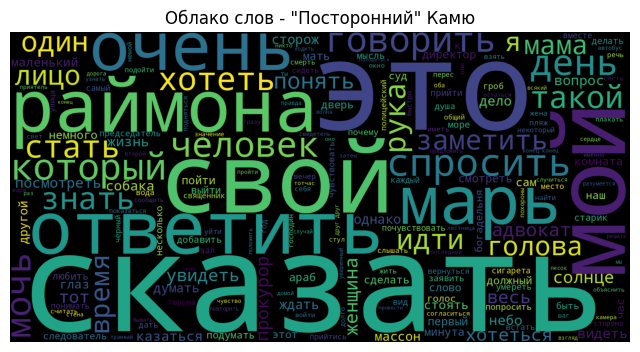

In [ ]:
text = ' '.join(the_stranger_lemmatized)

wordcloud = WordCloud(
    background_color ='black',
    width = 1600,
    height = 800,
).generate(text)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Облако слов - "Посторонний" Камю')
plt.show()

#Часть 4. Замена грамматических категорий

In [ ]:
from nltk.tokenize import sent_tokenize

In [ ]:
change_pos_general = sent_tokenize(the_stranger_text, language='russian')[150:160]
for sentence in change_pos_general:
    print(sentence, '\n')

Я не видел, что она делает, но по движению ее плеч и рук догадывался, что она вяжет. 

Было тепло, я согрелся от выпитого кофе; в открытую дверь вливались запахи летней ночи и цветов. 

Должно быть, я задремал. 

Проснулся я от какого-то шороха. 

Со сна стены морга показались мне невероятно сверкающей белизны. 

Вокруг не было ни малейшей тени, и каждая вещь, каждый угол, все изгибы вырисовывались так резко, что было больно глазам. 

Как раз тогда и пришли мамины друзья. 

Их было человек десять, и все они бесшумно двигались при этом ослепительном свете. 

Вот они расселись, но очень осторожно -- ни один стул не скрипнул. 

Я смотрел на них и видел так четко, как никогда еще никого не видел, я замечал каждую складочку на их лицах, каждую мелочь в одежде. 



In [ ]:
def change_number(word_parse):
    word = str()

    if word_parse.tag.number == 'sing':
        if word_parse.inflect({'plur'}) is None:
            word = word_parse.word
        else:
            word = word_parse.inflect({'plur'}).word

    elif word_parse.tag.number == 'plur':
        word = word_parse.inflect({'sing'}).word

    return(word)

In [ ]:
print(change_number(morph.parse('белизна')[0]))

белизна


In [ ]:
##я хотела сделать умно через import random, но было 23:38

def change_tense(word_parse):
    word = str()
    if word_parse.tag.tense == None:
        return word_parse.word
    elif word_parse.tag.tense == 'past':
        if word_parse.tag.aspect == 'impf':
            word = word_parse.inflect({'pres', '3per'}).word
        else:
            word = word_parse.inflect({'futr', '3per'}).word
    else:
        word = word_parse.inflect({'past'}).word

    return word

что я здесь не учитывала: примеры типа инфинитивов или императивов, у которых не определяется время: кажется достаточно странным его пытаться поменять, потому что во фразе "я хотел сказать" / "я хочу сказать" "сказать" выполняет не функцию глагола, несущего какие-то грамматические значения, а скорее предиката...  

короче, время не важно семантически, fmpv (и в принципе непонятно, как из None прийти во что-то адекватное)

другая проблема (которая не всплывает конкретно для этого абзаца, но это не делает ее меньшей проблемой) - это аналитические формы будущего времени (e.g. "будет говорить"), которые такой код считает как "был говорить" вместо "говорил"; но это довольно сложно решить неконтекстным анализатором, поэтому пока оставим это как временно нерешаемую задачу

In [ ]:
for sentence in change_pos_general:
    sentence_changed = list()
    for word in sentence.replace(',', '').replace('.', '').replace(':', '').split():
        word_parse = morph.parse(word)[0]
        if word_parse.tag.POS == 'NOUN':
            sentence_changed.append(change_number(word_parse))
        elif word_parse.tag.POS == 'VERB':
            sentence_changed.append(change_tense(word_parse))
        else:
            sentence_changed.append(word)
    print(' '.join(sentence_changed))

Я не видит что она делал но по движениям ее плеча и руки догадывается что она вязал
есть тепло я согреется от выпитого кофе; в открытую двери вливаются запах летней ночей и цвета
Должно быть я задремлет
проснётся я от какого-то шорохов
Со снов стен моргов покажутся мне невероятно сверкающей белизны
Вокруг не есть ни малейшей теней и каждая вещи каждый углы все изгиб вырисовываются так резко что есть больно глазу
Как раза тогда и пришли мамины друг
Их есть люди десять и все они бесшумно двигаются при этом ослепительном свете
Вот они расселись но очень осторожно -- ни один стулы не скрипнет
Я смотрит на них и видит так четко как никогда еще никого не видит я замечает каждую складочки на их лице каждую мелочи в одеждах


это просто изменение числа существительных и времени прилагательных; здесь есть какое-то количество синтаксических ошибок, это грустно (а еще оно не согласовывается нормально по роду и это еще грустнее)

(я поняла, что это нужно было делать через синтаксис, но я как-то очень не умею в дедлайны, поэтому не в этот раз)